# PA005: High Value Customer Identification (Insiders)

# 0.0 Imports

In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
from sqlalchemy import create_engine
import scipy.stats as st
from umap.umap_ import UMAP

from plotly import express as px


from sklearn.cluster import KMeans, DBSCAN

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

from sklearn.decomposition import PCA

from sklearn.manifold import TSNE

from sklearn.ensemble import RandomForestRegressor

from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score, silhouette_samples

from scipy.cluster.hierarchy import  linkage,dendrogram, fcluster

from sklearn.neighbors import NearestNeighbors


pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.filterwarnings("ignore")

# 0.2 Load Data

In [3]:
caminho = 'C:\\repos\\portfolio_projetos\\pa005_insider_clustering'
df_raw = pd.read_csv(caminho + '\\data\\raw\\Ecommerce.csv', encoding = 'iso 8859-1')
df_raw = df_raw.drop(['Unnamed: 8'], axis = 1)
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


# 1.0 Descrição os dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [4]:
cols_new = ['invoice_no','stock_code','description','quantity','invoice_date','unit_price','customer_id','country']

df1.columns = cols_new
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


## 1.2 Data dimension

In [5]:
print("Number of rows: {} \nNumber of columns: {}".format(df1.shape[0], df1.shape[1]))

Number of rows: 541909 
Number of columns: 8


## 1.3 Data types

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
df_missing = df1.loc[df1['customer_id'].isna() ]
df_not_missing = df1.loc[~df1['customer_id'].isna() ]
df_not_missing.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,17850.0000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,17850.0000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,17850.0000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,17850.0000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,17850.0000,United Kingdom


In [9]:
print('Missing => {}  and NOT missing => {}'.format(df_missing.shape[0],df_not_missing.shape[0]))

Missing => 135080  and NOT missing => 406829


In [10]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()
missing_invoice[0:9]

['536414',
 '536544',
 '536545',
 '536546',
 '536547',
 '536549',
 '536550',
 '536552',
 '536553']

In [11]:
df_not_missing.loc[df_not_missing['invoice_no'].isin( missing_invoice )]
# nao existe invoice_no do missing presente no not missing

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [12]:
# atribuição dos novos "customer_id", apenas para nao perder os dados dos 25%
#df_not_missing['customer_id'].max()  # 18287

In [13]:
# create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on = 'invoice_no', how = 'left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )
df1 = df1.drop(['customer_id_y','customer_id_x'], axis = 1)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.5500,United Kingdom,17850.0000
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.3900,United Kingdom,17850.0000
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.7500,United Kingdom,17850.0000
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.3900,United Kingdom,17850.0000
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.3900,United Kingdom,17850.0000


In [14]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

In [15]:
# com a mudança dos missings acima, rodar novamente as analises descritivas abaixo para verificar mudanças de comportamento

In [16]:
# # remove
# df1 = df1.dropna(subset = ['description','customer_id'])

# print('Removed data: {:.2f}%'.format(100*(1 - (df1.shape[0]/df_raw.shape[0]))))

In [17]:
# df1.isna().sum()

## 1.6 Change dtypes

In [18]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.5500,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.3900,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.7500,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.3900,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.3900,United Kingdom,17850


In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [20]:
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [21]:
# central tendency - mean / median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std / skew / kurtosis / min / max
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

# concatenate
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std', 'skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0000,80995.0000,161990.0000,9.5522,3.0000,218.0810,-0.2641,119769.1600
1,unit_price,-11062.0600,38970.0000,50032.0600,4.6111,2.0800,96.7598,186.5070,59005.7191
2,customer_id,12346.0000,22709.0000,10363.0000,16688.8405,16249.0000,2911.4087,0.4874,-0.8043


In [22]:
# quantidade com valor negativo ? (Devolução)
# preço unitario de zero ? Promoção ?


### 1.7.2 Categorical Attributes

In [23]:
# cat_attributes['invoice_no'].astype('int64')
# invoice_no
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x)) )]
print('Total of invoices with letter: ', df_letter_invoices.shape[0])
print('Total of invoices with letter and quantity < 0: ',df_letter_invoices.loc[
                                        df_letter_invoices['quantity'] < 0].shape[0])

Total of invoices with letter:  9291
Total of invoices with letter and quantity < 0:  9288


In [24]:
# stock code
# pegar somente letras
df1.loc[df1['stock_code'].apply( lambda x: bool(re.search('^[a-zA-Z]+$', x)) ),
                   'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [25]:
# acao:  remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']


In [26]:
# description
df1.head()

# delete description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.5500,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.3900,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.7500,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.3900,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.3900,United Kingdom,17850


In [27]:
# country
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [28]:
df1['country'].value_counts( normalize = True).head()

United Kingdom   0.9143
Germany          0.0175
France           0.0158
EIRE             0.0151
Spain            0.0047
Name: country, dtype: float64

In [29]:
df1[['country','customer_id']].drop_duplicates().groupby('country').count().sort_values(by = 'customer_id',
                                                                                        ascending = False).head()

,customer_id
country,
United Kingdom,7587
Germany,95
France,90
EIRE,44
Spain,31


# 2.0 Filtragem das variáveis

In [30]:
df2 = df1.copy()

In [31]:
df2.sort_values(['customer_id','invoice_no','description']).head(10) 
# há devolução se olhar o primeiro individuo, pois o "C" parece ser a flag para devolução

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2017-01-16,1.0400,United Kingdom,12346
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2017-01-16,1.0400,United Kingdom,12346
14966,537626,84558A,3D DOG PICTURE PLAYING CARDS,24,2016-12-05,2.9500,Iceland,12347
14939,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2016-12-05,4.2500,Iceland,12347
14948,537626,22725,ALARM CLOCK BAKELIKE CHOCOLATE,4,2016-12-05,3.7500,Iceland,12347
14949,537626,22726,ALARM CLOCK BAKELIKE GREEN,4,2016-12-05,3.7500,Iceland,12347
14952,537626,22729,ALARM CLOCK BAKELIKE ORANGE,4,2016-12-05,3.7500,Iceland,12347
14951,537626,22728,ALARM CLOCK BAKELIKE PINK,4,2016-12-05,3.7500,Iceland,12347
14950,537626,22727,ALARM CLOCK BAKELIKE RED,4,2016-12-05,3.7500,Iceland,12347
14955,537626,21171,BATHROOM METAL SIGN,12,2016-12-05,1.4500,Iceland,12347


In [32]:
# quantity (negative)
df2.loc[df2['quantity'] < 0 ].sort_values('invoice_no').head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
2406,536589,21777,NaN,-10,2016-11-29,0.0000,United Kingdom,19013
4347,536764,84952C,NaN,-38,2016-11-30,0.0000,United Kingdom,19019
7188,536996,22712,NaN,-20,2016-12-01,0.0000,United Kingdom,19036
7189,536997,22028,NaN,-20,2016-12-01,0.0000,United Kingdom,19037
7190,536998,85067,NaN,-6,2016-12-01,0.0000,United Kingdom,19038


In [33]:
#====== NUMERICAL ===========
# unity price > 0
df2 = df2.loc[df2['unit_price'] > 0.040]

# stock code != ['POST, D, M, DOT, CRUK]
df2 = df2.loc[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]

# description
df2 = df2.drop(['description'], axis = 1)

# country change
df2 = df2.loc[ ~df2['country'].isin( ['Unspecified','European Community'])]


# esse cliente apareceu com compras e estornos altos após o pandas profiling na etapa de verificar outliers
df2 = df2.loc[~df2['customer_id'].isin( [16446])]


# quantity
df2_returns = df2.loc[ df2['quantity'] < 0]
df2_purchases = df2.loc[ df2['quantity'] >= 0]

# 3.0 Feature Engineering

In [34]:
df3 = df2.copy()

## 3.1 Feature creation

In [35]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis = 1).drop_duplicates().reset_index(drop = True)

df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross revenue

In [36]:
# gross revenue = quantity * price (faturamento)
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

In [37]:
# monetary
df_monetary = df2_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

In [38]:
df_ref = pd.merge(df_ref, df_monetary, on = 'customer_id',how = 'left')

df_ref.isna().sum() # tem NA por conta de ser somente as compras 'positivas'

customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - day from last purchase

In [39]:
# recency - last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

# pego o df1 com max() pois eu considero que seria eu olhando pra "hoje" no meu dataset e tirando 'hoje - datas'
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date']  ).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.5 Quantity of unique products purchased

In [40]:
# number of products
df_frequency = df2_purchases[['customer_id','stock_code']].groupby(
                                'customer_id').count().reset_index().rename(columns={'stock_code':'qtde_products'})
df_ref = pd.merge(df_ref, df_frequency, on = 'customer_id', how = 'left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
dtype: int64

In [41]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_products
0,17850,5391.2100,372.0000,297.0000
1,13047,3232.5900,56.0000,171.0000
2,12583,6705.3800,2.0000,232.0000
3,13748,948.2500,95.0000,28.0000
4,15100,876.0000,333.0000,3.0000


### 3.1.7 Frequency purchase

In [42]:
df2[['invoice_no','customer_id','invoice_date']].drop_duplicates().head()

,invoice_no,customer_id,invoice_date
0,536365,17850,2016-11-29
7,536366,17850,2016-11-29
9,536367,13047,2016-11-29
21,536368,13047,2016-11-29
25,536369,13047,2016-11-29


In [43]:
df_aux = df2_purchases[['invoice_no','customer_id','invoice_date']].drop_duplicates().groupby('customer_id').agg(
                    max_ = ('invoice_date','max'),
                    min_ = ('invoice_date','min'),
                    days_ = ('invoice_date',lambda x: (x.max() - x.min()).days + 1),
                    buy_ = ('invoice_date','count')).reset_index()

# frequency
df_aux['frequency'] = df_aux[['days_','buy_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0
                                                else 0, axis = 1)
# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on = 'customer_id', how = 'left')
df_ref

,customer_id,gross_revenue,recency_days,qtde_products,frequency
0,17850,5391.2100,372.0000,297.0000,17.0000
1,13047,3232.5900,56.0000,171.0000,0.0283
2,12583,6705.3800,2.0000,232.0000,0.0403
3,13748,948.2500,95.0000,28.0000,0.0179
4,15100,876.0000,333.0000,3.0000,0.0732
...,...,...,...,...,...
5781,22706,5699.0000,1.0000,634.0000,1.0000
5782,22707,6756.0600,0.0000,730.0000,1.0000
5783,22708,3217.2000,0.0000,59.0000,1.0000
5784,22709,3950.7200,0.0000,217.0000,1.0000


In [44]:
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
dtype: int64

### 3.1.8 Number of returns

In [45]:
df_returns = df2_returns[['customer_id','quantity']].groupby('customer_id').sum().reset_index()
df_returns.rename(columns = {'quantity':'qtde_returns'}, inplace = True)

df_returns['qtde_returns'] = df_returns['qtde_returns'] * ( -1 )

df_ref = pd.merge(df_ref, df_returns, on = 'customer_id', how = 'left')

df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

# 4.0 EDA (exploratory data analysis)

In [46]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_products    0
frequency        0
qtde_returns     0
dtype: int64

In [47]:
df4.shape

(5695, 6)

## 4.3 Space Study

In [48]:
# original dataset
# df43 = df4.drop(['customer_id'], axis = 1).copy()

# selected dataset
cols_selected = ['customer_id','gross_revenue','recency_days','qtde_products','frequency','qtde_returns']
df43 = df4[cols_selected].drop(['customer_id'], axis = 1).copy()
df43.head()

,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,5391.2100,372.0000,297.0000,17.0000,40.0000
1,3232.5900,56.0000,171.0000,0.0283,35.0000
2,6705.3800,2.0000,232.0000,0.0403,50.0000
3,948.2500,95.0000,28.0000,0.0179,0.0000
4,876.0000,333.0000,3.0000,0.0732,22.0000


In [49]:
# rescaling/standartization
mm = MinMaxScaler()
# ss = StandardScaler()
# rs = RobustScaler()

df43['gross_revenue'] = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days'] = mm.fit_transform( df43[['recency_days']] )
df43['qtde_products'] = mm.fit_transform( df43[['qtde_products']] )
df43['frequency'] = mm.fit_transform( df43[['frequency']] )

df43['qtde_returns'] = mm.fit_transform( df43[['qtde_returns']] )

In [50]:
X = df43.copy()
X.shape

(5695, 5)

### 4.3.1 PCA

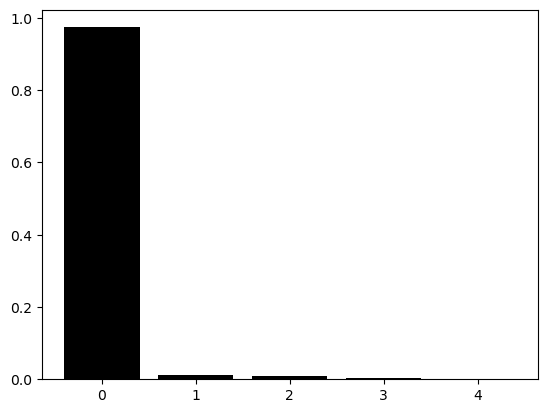

In [51]:
pca = PCA( n_components = X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explainable variables
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color = 'black')

# pca component
df_pca = pd.DataFrame( principal_components )

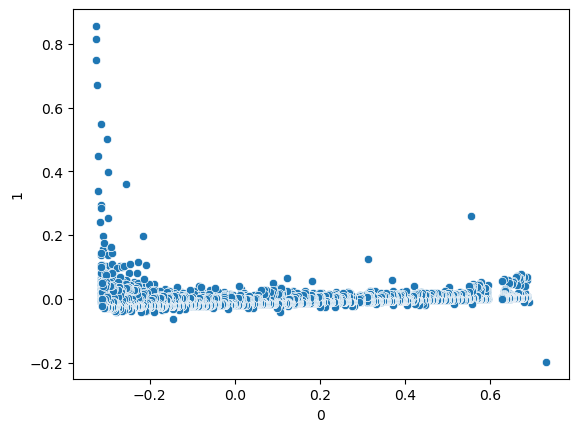

In [52]:
sns.scatterplot( x=0, y = 1, data = df_pca );

### 4.3.2 UMAP

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

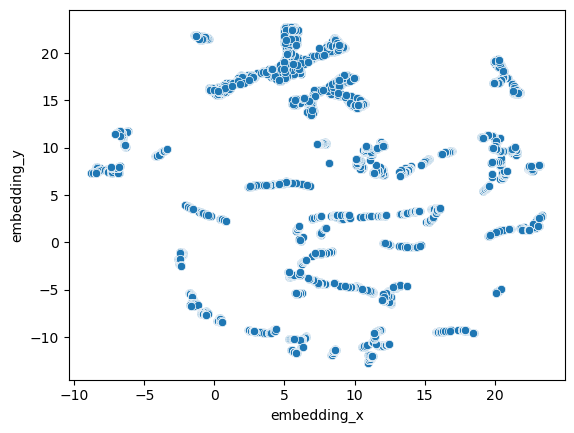

In [53]:
reducer = UMAP( random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:,0]
df_umap['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_umap)

### 4.3.3 t-SNE

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

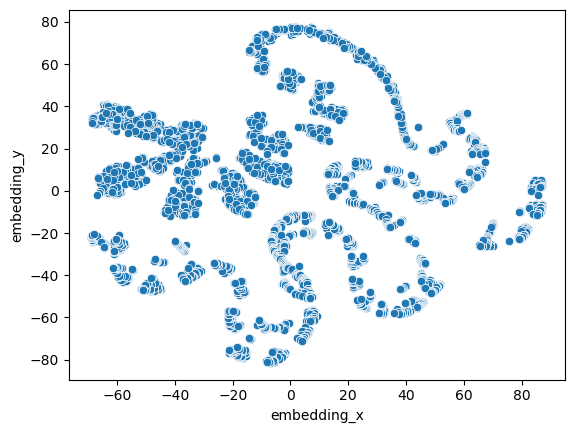

In [54]:
reducer = TSNE( n_components = 2, random_state = 42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:,0]
df_tsne['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_tsne)

### 4.3.4 Tree-Based Embedding

In [55]:
# training dataset
X = df43.drop(['gross_revenue'], axis = 1)
Y = df43['gross_revenue']

# model definition
rf_model = RandomForestRegressor( n_estimators=100, random_state = 42)

# model training
rf_model.fit(X, Y)

# leaf
df_leaf = pd.DataFrame( rf_model.apply(X) )
print(df_leaf.shape)

(5695, 100)


<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

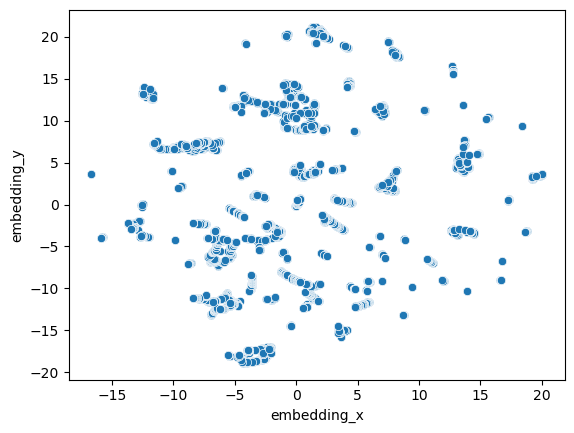

In [56]:
reducer = UMAP( random_state = 42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:,0]
df_tree['embedding_y'] = embedding[:,1]

# plot UMAP
sns.scatterplot( x = 'embedding_x', y = 'embedding_y',data = df_tree)

# 5.0 Data Preparation

In [126]:
# tree-based embedding
df5 = df_tree.copy()
d5.to_csv(caminho + '\\src\\data\\tree_based_embedding.csv', index = False)

# tree-based embedding
# df5 = df_umap.copy()

# tree-based embedding
# df5 = df_tsne.copy()

# 7.0 Hyperparameter Fine Tunning

In [97]:
X = df5.copy()
X.head()

,embedding_x,embedding_y
0,85.7287,-1.8677
1,10.3656,37.6700
2,-44.7644,30.4436
3,-9.6890,74.0240
4,52.8239,22.3119


In [98]:
# clusters = [2,3,4,5,6,7]
clusters = np.arange(2, 25, 1)

## 7.1 K-Means

In [99]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = KMeans(n_clusters = k, n_init = 100, random_state = 42)

    # model training
    kmeans_model.fit( X )


    # model prediction
    labels = kmeans_model.predict( X )

    # model evaluation
    sil = silhouette_score( X, labels, metric = 'euclidean')
    kmeans_list.append( sil )
#     print(sil)

Text(0.5, 1.0, 'Silhouette Score  x  K clusters')

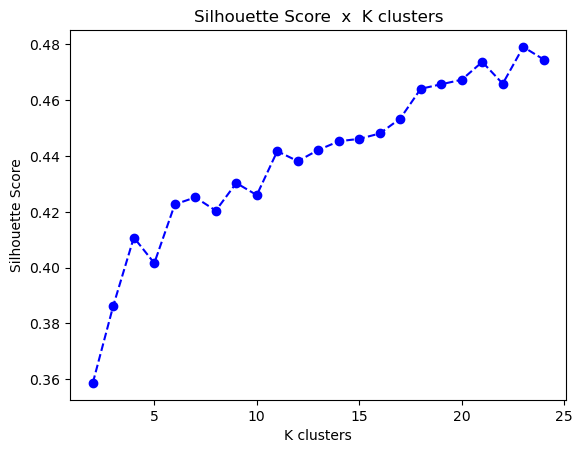

In [100]:
plt.plot( clusters, kmeans_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score  x  K clusters')

## 7.2 GMM

In [101]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = GaussianMixture(n_components = k, n_init = 10, random_state = 42)

    # model training
    gmm_model.fit( X )


    # model prediction
    labels = gmm_model.predict( X )

    # model evaluation
    sil = silhouette_score( X, labels, metric = 'euclidean')
    gmm_list.append( sil )
#     print(sil)

Text(0.5, 1.0, 'Silhouette Score  x  GMM clusters')

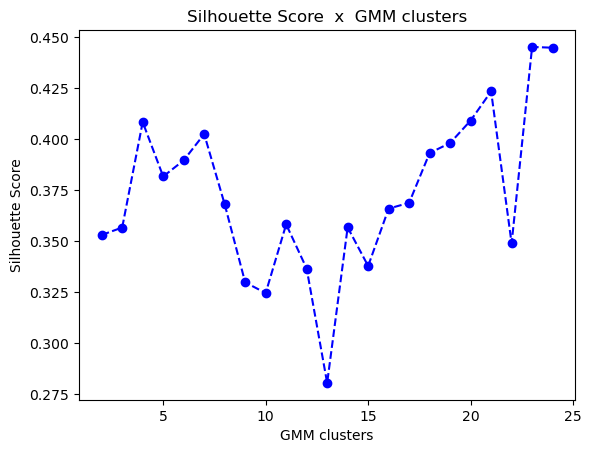

In [102]:
plt.plot( clusters, gmm_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('GMM clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score  x  GMM clusters')

## 7.3 Hierarchical Clustering

In [103]:
# model definition and training
hc_model = linkage( X, 'ward')

### 7.3.1 H-Clustering Silhouette Score

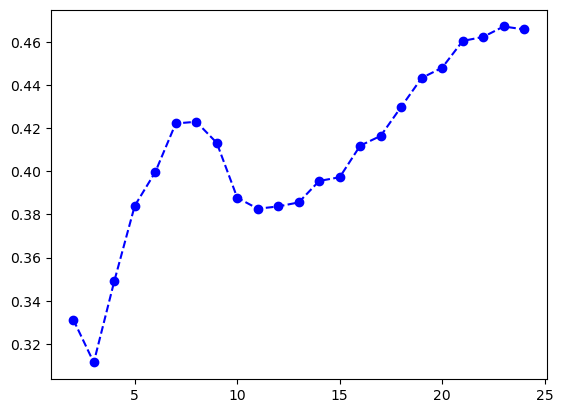

In [104]:
hc_list = []

for k in clusters:
    # model definition and training
    hc_model = linkage( X, 'ward')

    # model predict
    labels = fcluster( hc_model, t=k, criterion = 'maxclust' )

    # metrics
    sil = silhouette_score( X, labels, metric = 'euclidean' )
#     print(sil)
    hc_list.append(sil)
    
plt.plot( clusters, hc_list, linestyle = '--', marker = 'o', color = 'b');

## 7.5 Results

In [75]:
# tree-based
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM':gmm_list,
    'HC':hc_list} ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.421771,0.419299,0.403612,0.427597,0.418075,0.435127,0.443684,0.457828,0.476907,0.483791,0.490489,0.503938,0.518349,0.525299,0.532810,0.529540,0.533960,0.536333,0.547602,0.560620,0.566721,0.572251,0.577588
GMM,0.421520,0.408631,0.371223,0.379122,0.342845,0.309858,0.288054,0.402399,0.414188,0.414718,0.379013,0.450227,0.451618,0.441353,0.422179,0.423460,0.445435,0.463953,0.501845,0.433171,0.492405,0.545397,0.468163
HC,0.348990,0.304687,0.359145,0.380326,0.406255,0.406526,0.429230,0.428657,0.422292,0.434106,0.453874,0.468612,0.481898,0.492014,0.503175,0.514198,0.520080,0.528415,0.527474,0.541861,0.551641,0.564020,0.572889


In [89]:
# umap
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM':gmm_list,
    'HC':hc_list} ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.429525,0.462432,0.481702,0.473352,0.474931,0.482425,0.430128,0.436584,0.444601,0.464409,0.499770,0.519313,0.531960,0.538380,0.547072,0.558742,0.570363,0.578626,0.578618,0.570117,0.578346,0.569899,0.603378
GMM,0.398454,0.441686,0.466726,0.463681,0.414193,0.338520,0.452251,0.416837,0.353069,0.380927,0.417105,0.408684,0.477702,0.506071,0.495301,0.484304,0.520041,0.512614,0.451882,0.549538,0.527483,0.535823,0.537085
HC,0.372304,0.402446,0.412910,0.429573,0.458218,0.470299,0.455686,0.423133,0.440430,0.449047,0.482008,0.498727,0.518881,0.524372,0.539553,0.547636,0.560113,0.560936,0.570594,0.558558,0.565999,0.584894,0.590413


In [105]:
# t-sne
df_results = pd.DataFrame(
    {'KMeans': kmeans_list,
    'GMM':gmm_list,
    'HC':hc_list} ).T

df_results.columns = clusters
df_results.style.highlight_max(color = 'lightgreen', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.358707,0.386391,0.410798,0.401629,0.422657,0.425187,0.420420,0.430319,0.426001,0.441740,0.438141,0.442159,0.445275,0.446146,0.448063,0.453429,0.464082,0.465699,0.467330,0.473706,0.465901,0.479078,0.474562
GMM,0.352949,0.356591,0.408258,0.381609,0.389501,0.402391,0.367991,0.329724,0.324481,0.358130,0.336486,0.280444,0.356660,0.337739,0.365856,0.368695,0.393108,0.398002,0.409010,0.423280,0.348832,0.445087,0.444693
HC,0.331309,0.311434,0.349052,0.384022,0.399581,0.422134,0.422915,0.413174,0.387751,0.382645,0.383704,0.385569,0.395506,0.397227,0.411853,0.416379,0.429827,0.443206,0.447965,0.460334,0.462218,0.467046,0.465677


# 8.0 Model Training

## 8.2 GMM

In [109]:
k = 8

gmm_model = GaussianMixture(n_components = k, n_init = 300, random_state = 32)

# model training
gmm_model.fit( X )


# model prediction
labels = gmm_model.predict( X )

# model evaluation
sil = silhouette_score( X, labels, metric = 'euclidean')
#     print(sil)

### 8.2.1 Cluster Validation

In [110]:
# WSS
# print('WSS score: {}'.format(kmeans.inertia_))

## SS
print('SS score: {}'.format(sil))

SS score: 0.2322438359260559


# 9.0 Cluster Analysis

In [111]:
df9 = X.copy()
df9['cluster'] = labels

## 9.2  Visualization Inspection - GMM

<AxesSubplot: xlabel='embedding_x', ylabel='embedding_y'>

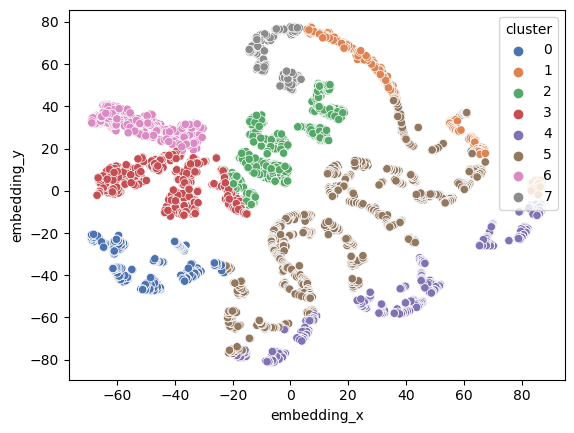

In [112]:
sns.scatterplot(x = 'embedding_x',y='embedding_y', data = df9, hue = 'cluster', palette = 'deep') #8

## 9.2 Cluster Profile

In [113]:
df92 = df4[cols_selected].copy()
# df92['cluster'] = labels_kmeans
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.2100,372.0000,297.0000,17.0000,40.0000,1
1,13047,3232.5900,56.0000,171.0000,0.0283,35.0000,2
2,12583,6705.3800,2.0000,232.0000,0.0403,50.0000,6
3,13748,948.2500,95.0000,28.0000,0.0179,0.0000,7
4,15100,876.0000,333.0000,3.0000,0.0732,22.0000,5


In [114]:
# number of customer
df_cluster = df92[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_cluster'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# average gross revenue
df_cluster_gross_revenue = df92[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_gross_revenue, on = 'cluster', how = 'inner')

# average recency days
df_cluster_recency_days = df92[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_recency_days, on = 'cluster', how = 'inner')

# average qtd products
df_cluster_invoice_no = df92[['qtde_products','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'inner')

# average frequency
df_cluster_invoice_no = df92[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'inner')

# average returns
df_cluster_invoice_no = df92[['qtde_returns','cluster']].groupby('cluster').mean().reset_index()
df_cluster = df_cluster.merge(df_cluster_invoice_no, on = 'cluster', how = 'inner')


df_cluster.sort_values(by=['gross_revenue'], ascending = False)

,cluster,customer_id,perc_cluster,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
6,6,480,8.4284,8653.0858,3.5979,308.9396,0.0582,99.7750
3,3,748,13.1343,2151.4094,14.4920,120.3703,0.0367,26.2353
2,2,785,13.7840,1705.2666,41.7962,98.8904,0.0282,14.7019
7,7,305,5.3556,1344.3750,85.8361,66.1607,0.0263,7.7902
0,0,452,7.9368,1029.1473,20.0088,82.7832,1.0540,1.2987
1,1,472,8.2880,745.2326,228.2225,44.8051,0.4639,7.7161
4,4,724,12.7129,728.6587,212.0414,49.5359,1.0068,3.7818
5,5,1729,30.3600,722.0573,187.4297,55.9740,0.9294,51.8641


In [115]:
# 6 Cluster Insiders
# 3 Cluster More Products
# 2 Cluster Spend Money
# 7 Cluster Even More Products
# 0 Cluster Less Days
# 1 Cluster Less 1k
# 4 Cluster Stop Returners
# 5 Cluster More Buy

- Cluster 01 (Insiders):
    - Número de clientes: 468 (15 % do total)
    - Recência média de 21 dias
    - Compras em média de 424 compras
    - Receita média de $ 8835,90
    

- Cluster 02:
    - Número de clientes: 31 (0,71 % do total)
    - Recência média de 13 dias
    - Compras em média de 53 compras
    - Receita média de $ 40.543,52


- Cluster 03:
    - Número de clientes: 4335 (99,15 % do total)
    - Recência média de 92 dias
    - Compras em média de 4 compras
    - Receita média de $ 1372,58

# 10 EDA - Hypothesis

In [116]:
df10 = df92.copy()
df10.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.2100,372.0000,297.0000,17.0000,40.0000,1
1,13047,3232.5900,56.0000,171.0000,0.0283,35.0000,2
2,12583,6705.3800,2.0000,232.0000,0.0403,50.0000,6
3,13748,948.2500,95.0000,28.0000,0.0179,0.0000,7
4,15100,876.0000,333.0000,3.0000,0.0732,22.0000,5


# 11.0 Deploy to Production

In [117]:
for i in ['recency_days','qtde_returns','qtde_products']:
    df92[i] = df92[i].astype('int64')

In [13]:
banco = 'sqlite:///' + caminho + '\\notebooks\\insiders_db.sqlite'
banco

'sqlite:///C:\\repos\\portfolio_projetos\\pa005_insider_clustering\\notebooks\\insiders_db.sqlite'

In [14]:
conn = create_engine(banco)

In [15]:
query_truncate_table_insiders = """ DROP TABLE insiders"""
conn.execute( query_truncate_table_insiders )

In [16]:
# create table
query_create_insiders = """
    CREATE TABLE insiders (
    customer_id      INTEGER,
    gross_revenue    REAL,
    recency_days     INTEGER,
    qtde_products    INTEGER,
    frequency        REAL,
    qtde_returns     INTEGER,
    cluster          INTEGER
    )
    """

# conn = sqlite3.connect('insiders_db.sqlite')
conn.execute( query_create_insiders )
# conn.commit()
# conn.close()

In [17]:
# # insert data
df92.to_sql('insiders',con = conn, if_exists = 'append', index = False)

NameError: name 'df92' is not defined

In [122]:
# select data
query = """ SELECT * FROM insiders"""
df_query = pd.read_sql( query, conn)
df_query

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,cluster
0,17850,5391.2100,372,297,17.0000,40,1
1,13047,3232.5900,56,171,0.0283,35,2
2,12583,6705.3800,2,232,0.0403,50,6
3,13748,948.2500,95,28,0.0179,0,7
4,15100,876.0000,333,3,0.0732,22,5
...,...,...,...,...,...,...,...
5690,22706,5699.0000,1,634,1.0000,0,0
5691,22707,6756.0600,0,730,1.0000,0,0
5692,22708,3217.2000,0,59,1.0000,0,0
5693,22709,3950.7200,0,217,1.0000,0,0


In [ ]:
# call C:\Users\pedro\miniconda3\condabin\activate.bat
# conda activate pa005insiderclustering
# cd C:\repos\portfolio_projetos\pa005_insider_clustering
# set data_python=%date:~6,4%-%date:~3,2%-%date:~0,2%%time:~0,2%:%time:~3,2%:%time:~6,2%
# set path_pa005=C:\repos\portfolio_projetos\pa005_insider_clustering
# papermill %path_pa005%\notebooks\c0.10-Deploy.ipynb %path_pa005%\notebooks\c0.11-Deploy_%data_python%.ipynb